<a href="https://colab.research.google.com/github/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_marketplaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regulatron: Experimento de classificação 3

## Experimento anterior

O [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb) foi a segunda experiência no tratamento dos dados brutos obtidos no Regulatron, a ferramenta de raspagem de dados veiculados em anúncios de produtos para telecomunicações publicados em alguns dos principais marketplaces do país. 

De forma geral, o experimento consiste na construção de um classificador automático, utilizando algoritmos de aprendizagem de máquina, para identificar anúncios de produtos passíveis de homologação compulsória pela Anatel. 

A abordagem utilizada foi classificação de texto por aprendizagem de máquina supervisionada. Classificação de texto, ou categorização de texto, é a técnica empregada para analisar documentos e a eles atribuir categorias previamente definidas. Nessa abordagem é utilizado um conjunto de dados rotulados para treinamento, ou seja, um conjunto de anúncios previamente analisados por um humano, indicando os produtos anunciados são passíveis de homologação compulsória pela Anatel.

A figura a seguir ilustra um sistema típico de classificação de texto por aprendizagem de máquina supervisionada. 

![Classificador de texto](assets/supervised_text_classification.png)

## Experimento atual

O resultados do [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb) foram limitados em razão dos poucos dados utilizados para treinar os classificadores: a amostra foi pequena e extraída de apenas um dos sites de comércio eletrônico cujos anúncios foram raspados pelo Regulatron.

Para preencher essa lacuna foi realizado um esforço de rotulagem que resultou em uma amostra com 18.836 exemplos, extraídas de três marketplaces cujos dados de raspagem estavam disponíveis no momento: Amazon, Magazine Luiza e Mercado Livre. De posse dos dados, o classificador foi treinado com o mesmos parâmetros do [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb) para que fossem observados os efeitos da quantidade de exemplos no desempenho do classificador.

Adicionalmente, o classificador retreinado foi validado com dados da fiscalização de supervisão de mercado disponíveis à época de realização do experimento 3. 



## Dados e dependências

Se você estiver executando esse notebook localmente, precisará copiar os dados manualmente. Para fazer isso copie o arquivo [assets.zip](https://raw.githubusercontent.com/maxwelfreitas/RegulatronClassificacao2/main/assets.zip) para o mesmo diretório que o notebook e extraia todo seu conteúdo para que fique em uma subpasta *assets*.

Se estiver executando esse notebook em ambiente Linux ou no Google Colab, execute as células a seguir para obter e extrair os dados e instalar as dependências:

In [1]:
# !rm -f assets.zip
# !wget -qnv https://raw.githubusercontent.com/InovaFiscaliza/dados-pacp/main/experimentos/assets.zip
# !unzip -q -o assets.zip
# !pip install -q unidecode

## Bibliotecas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import unidecode
import warnings 

from joblib import load, dump

from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from string import punctuation

from wordcloud import WordCloud

In [3]:
download('stopwords', quiet=True)
download('punkt', quiet=True)

True

## Constantes e funções auxiliares

In [4]:
NULL_STRING = '#NULLO#'
MAX_CAT_COUNT = 3
FILE_MODEL_CLF2 = 'assets/exp_clf2_model.joblib'
FILE_MODEL_CLF3 = 'assets/exp_clf3_model.joblib'

In [5]:
def plot_donut(labels,values,title,startangle=30, center_number=None):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    if center_number is not None:
        ax.annotate(center_number,xy=[0,0],
                    horizontalalignment='center',
                    verticalalignment='center')
    
    ax.set_title(title)
    plt.show()

In [6]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unidecode.unidecode(doc)
    
    # uniformizar termos
    patterns = [('wi\s?.?fi', 'wifi'), 
                ('2,4', '2.4'), 
                ('5,8', '5.8')]
    for pattern, repl in patterns:
        doc = re.sub(pattern, repl, doc)
    
    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(punctuation))
    # stopwords específicas do domínio
    stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
    # cores mais comumns
    stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
    # stop_words.remove('sem') 
    
    tokens = [token for token in word_tokenize(doc) if token not in stop_words]

    # tokens = [token for token in re.findall(r'\b\w\w+\b',doc) if token not in stop_words]
    
    return tokens

def clean_text(doc):
    tokens = tokenizer(doc)
    return ' '.join(tokens) 

In [7]:
def plot_wordcloud(wc_docs,max_words=50,ax=None,title='Principais palavras'):

    if hasattr(wc_docs, '__iter__'):
        wc_docs = ' '.join(wc_docs)
   
    wc = WordCloud(max_words=max_words,height=300).generate(wc_docs)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))
        show_plt = True
    else: 
        show_plt = False
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)

    if show_plt:
        plt.show()

In [8]:
def plot_products_matrix(docs_matrix, targets=None, title=None, showlegend=False, legend_map=None, ax=None):
    
    pca = TruncatedSVD(n_components=2)
    pca_matrix = pca.fit_transform(docs_matrix)
    scatter_x = pca_matrix[:, 0] # first principle component
    scatter_y = pca_matrix[:, 1] # second principle component

    if ax is None:
        fig,ax = plt.subplots(figsize=(6,5))
        showplot = True
    else:
        showplot = False
    
    for group in np.unique(targets):
        if legend_map is not None:
            group_label = legend_map[group]
        else:
            group_label = group
        ix = np.where(targets == group)
        ax.scatter(scatter_x[ix], scatter_y[ix], label=group_label, s=5)
        if title is not None:
            ax.set_title(title)
    
    ax.set_xticks([])
    ax.set_yticks([])

    if showlegend:
        ax.legend()

    if showplot:
        plt.show()

In [9]:
def plot_models_benchmark(models, df):

    results = []
    docs = df['titulo']
    targets = df['passivel_homologacao']

    print('=' * 40)
    for model, name in models:
        
        acc = model.score(docs, targets)
        auc = roc_auc_score(targets,model.predict_proba(docs)[:,1])
        y_scores = model.decision_function(docs)
        fpr,tpr,auc_thresholds = roc_curve(targets,y_scores)
    
        model_results = {
            'name': name, 
            'acc': acc, 
            'auc': auc, 
            'fpr': fpr, 
            'tpr': tpr, 
            'auc_thresholds': auc_thresholds
        }
        
        results.append(model_results)
        
        print(name)
        print(f'Acurácia: {acc:.3f}')
        print('_' * 40)
        print()

    fig, ax = plt.subplots(1,1,figsize=(6,6))

    for result in results:

        name = result['name'] 
        auc = result['auc']
        fpr = result['fpr']
        tpr = result['tpr']
    
        ax.plot(fpr,tpr,label=f'{name}: {auc:.3f}')
  
    ax.set_xticks([0,0.5,1])
    ax.set_yticks([0,0.5,1])
    
    # remove the frame of the chart
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_title('Curva ROC')
    ax.set_xlabel('Taxa de falsos positivos')
    ax.set_ylabel('Taxa de verdadeiros positivos')
    
    ax.legend(loc='lower right')
    
    plt.show()

    return results

# O processo de rotulagem

O processo de rotulagem foi realizado por meio de atribuição de tarefas no Fiscaliza e executado por agentes de fiscalização que deveriam responder a 7 perguntas sobre cada anúncio com base no título e na descrição (quando presente):

1. O título do anúncio é bem elaborado?
2. O título do anúncio identifica o produto?
3. A descrição do anúncio é bem elaborada?
4. A descrição do anúncio identifica produto?
5. O produto é passível de homologação?
6. O produto é transmissor de radiofrequência?
7. Qual o tipo do produto anunciado?

Todas as perguntas possuíam respostas pré-definidas: 

- Perguntas 1 e 2: Sim ou Não;
- Perguntas 3 e 4: Sim, Não ou Anúncio não possui descrição;
- Perguntas 5 e 6: Sim, Não ou Não é possível afirmar; e
- Pergunta 7: foram listadas 15 categorias relevantes para a fiscalização, além das respostas Outro tipo/categoria e Não é possível afirmar.

Para saber mais sobre o processo de rotulagem consulte o [arquivo PDF com instruções de rotulagem](assets/rotulagem.pdf)
  

## Anúncios extraídos dos *marketplaces*

A base de dados utilizada neste experimento é uma amostra com 18.836 anúncios raspados dos *marketplaces* Amazon, Magazine Luiza e Mercado Livre. A seleção da amostra foi aleatória e não foram realizados nenhuma filtragem, segmentação ou agrupamento, assim, a quantidade de exemplos de cada *marketplace* é proporcional à quantidade de anúncios raspados anteriormente à rotulagem. 

In [10]:
file_marketplaces = 'assets/marketplaces.parquet'

df_marketplaces = pd.read_parquet(file_marketplaces)
df_marketplaces['titulo_clean'] = df_marketplaces['titulo'].map(clean_text)
map_groups = {(0,0):0, (1,0):1, (1,1):2}
df_marketplaces['grupo'] = df_marketplaces.apply(lambda row: (row['passivel_homologacao'],row['transmissor_rf']),axis=1).map(map_groups).fillna(3).astype(int)

map_marketplaces = {
    'amazon': 'Amazon', 
    'magalu': 'Magazine Luiza', 
    'mercadolivre': 'Mercado Livre'
}

df_sample_size = df_marketplaces[['id', 'marketplace']].groupby('marketplace',as_index=False).count()
df_sample_size.columns = ['Marketplace', 'Quantidade']
df_sample_size['Marketplace'] = df_sample_size['Marketplace'].map(map_marketplaces)

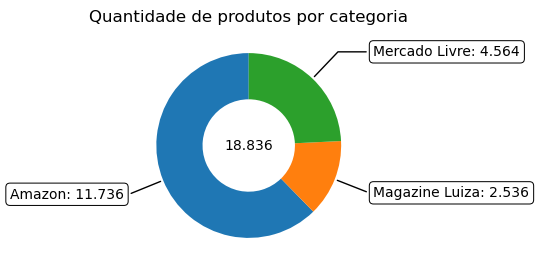

In [11]:
total = df_sample_size['Quantidade'].sum()
total = f'{total:_}'.replace('_','.')

labels = df_sample_size.apply(lambda row: f'{row.Marketplace}: {row.Quantidade:,d}'.replace(',','.'),axis=1)
values = df_sample_size['Quantidade'].to_numpy()
title = 'Quantidade de produtos por categoria'
startangle = 90

plot_donut(labels, values, title, startangle, total)

## Análise exploratória da amostra rotulada

### Tipos de produtos

Do total de exemplos, aproximadamente 55% dos produtos não foram enquadrados em uma das categorias previamente definidas: ou eram de outros tipos ou não foram identificadas pelo fiscal.

In [12]:
df_tipo_produto = df_marketplaces[['tipo_produto','id']].groupby('tipo_produto').count()
df_tipo_produto = df_tipo_produto.sort_values(by='id',ascending=False)
df_tipo_produto.columns = ['Quantidade']
df_tipo_produto.index.name = 'Tipo de produto'

total_items = df_tipo_produto['Quantidade'].sum()
df_tipo_produto.loc['Total'] = total_items
df_tipo_produto['Quantidade %'] = round(df_tipo_produto['Quantidade']/total_items*100,2)

df_tipo_produto

,Quantidade,Quantidade %
Tipo de produto,,
Outro tipo/categoria (não listada acima),8243,43.76
Transceptor de radiação restrita (2.4GHz/5.8GHz),3529,18.74
Não é possível afirmar,1502,7.97
Carregador para celular (inclusive powerbank),1359,7.21
Smartphones,1177,6.25
Drone,758,4.02
Transceptor de radiofrequência (VHF/UHF),464,2.46
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz),458,2.43
Bateria de lítio para celular,439,2.33


### Qualidade do título e descrição

Os títulos dos anúncios são, em geral, bem elaborados (aproximadamente 64%) e identificam o produto (aproximadamente 90%), já as descrições não estão presentes em quase metade dos anúncios e, quando presentes, são em geral bem elaboradas e identificam o produto.

In [13]:
map_titulo = {0: 'Não', 1: 'Sim'}
df_titulo = df_marketplaces.pivot_table(index='titulo_bem_elaborado',columns='titulo_identifica_produto',values='id',aggfunc='count')
df_titulo.columns = df_titulo.columns.map(map_titulo)
df_titulo.columns.name = 'Título identifica o produto?'
df_titulo.index = df_titulo.index.map(map_titulo)
df_titulo.index.name = 'Título bem elaborado?'
df_titulo['Total'] = df_titulo.sum(axis=1)
df_titulo.loc['Total'] = df_titulo.sum(axis=0)

df = df_titulo.style.format(precision=3, thousands=".", decimal=",")
display(df)

Título identifica o produto?,Não,Sim,Total
Título bem elaborado?,,,
Não,1.662,5.064,6.726
Sim,304,11.806,12.110
Total,1.966,16.870,18.836


In [14]:
map_desc = {0: 'Não', 1: 'Sim', 2: 'Anúncio não possui descrição'}
df_desc = df_marketplaces.pivot_table(index='desc_bem_elaborada',columns='desc_identifica_produto',values='id',aggfunc='count')
df_desc = df_desc.fillna(0).astype(int)
df_desc.columns = df_desc.columns.map(map_desc)
df_desc.columns.name = 'Descrição identifica o produto?'
df_desc.index = df_desc.index.map(map_desc)
df_desc.index.name = 'Descrição bem elaborada?'
df_desc['Total'] = df_desc.sum(axis=1)
df_desc.loc['Total'] = df_desc.sum(axis=0)

df = df_desc.style.format(precision=3, thousands=".", decimal=",")
display(df)

Descrição identifica o produto?,Não,Sim,Anúncio não possui descrição,Total
Descrição bem elaborada?,,,,
Não,921,1.507,0,2.428
Sim,232,6.989,0,7.221
Anúncio não possui descrição,0,0,9.187,9.187
Total,1.153,8.496,9.187,18.836


In [15]:
df_desc = df_desc.iloc[:2,:2]
df_desc['Total'] = df_desc.sum(axis=1)
df_desc.loc['Total'] = df_desc.sum(axis=0)

df = df_desc.style.format(precision=3, thousands=".", decimal=",")
display(df)

Descrição identifica o produto?,Não,Sim,Total
Descrição bem elaborada?,,,
Não,921,1.507,2.428
Sim,232,6.989,7.221
Total,1.153,8.496,9.649


### Produtos transmissores de radiofrequência

Os produtos identificados como transmissores de radiofrequência representam cerca de 42% do total de anúncios e quase 80% dos produtos passíveis de homologação. Ressalta-se que a marcação de um produto como transmissor de radiofrequência ou não foi feita exclusivamente com base no título e na descrição, quando disponível.

In [16]:
map_passivel = {0: 'Não', 1: 'Sim', 2: 'Não é possível afirmar'}
df_passivel = df_marketplaces.pivot_table(index='passivel_homologacao',columns='transmissor_rf',values='id',aggfunc='count')
df_passivel = df_passivel.fillna(0).astype(int)
df_passivel.columns = df_passivel.columns.map(map_passivel)
df_passivel.columns.name = 'Produto transmissor de RF?'
df_passivel.index = df_passivel.index.map(map_passivel)
df_passivel.index.name = 'Produto passível de homologação?'
df_passivel['Total'] = df_passivel.sum(axis=1)
df_passivel.loc['Total'] = df_passivel.sum(axis=0)

df = df_passivel.style.format(precision=3, thousands=".", decimal=",")
display(df)

Produto transmissor de RF?,Não,Sim,Não é possível afirmar,Total
Produto passível de homologação?,,,,
Não,7.473,0,2,7.475
Sim,1.978,7.888,53,9.919
Não é possível afirmar,68,0,1.374,1.442
Total,9.519,7.888,1.429,18.836


In [17]:
df_passivel = df_passivel.iloc[:2,:2]
df_passivel['Total'] = df_passivel.sum(axis=1)
df_passivel.loc['Total'] = df_passivel.sum(axis=0)

df = df_passivel.style.format(precision=3, thousands=".", decimal=",")
display(df)

Produto transmissor de RF?,Não,Sim,Total
Produto passível de homologação?,,,
Não,7.473,0,7.473
Sim,1.978,7.888,9.866
Total,9.451,7.888,17.339


## Visualização da amostra rotulada no espaço vetorial

A amostra de anúncios rotulados foi separada em dois grupos: não passíveis e passíveis de homologação compulsória a fim de observar se a distribuição dos documentos no espaço vetorial seria semelhante à distribuição observada no [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb).

Como esperado, observou-se uma separação entre os grupos, indicando a manutenção da viabilidade de construção de um classificador. 

Quando observadas as palavras mais frequentes em cada grupo observa-se que há palavras discriminantes das categorias, contudo, palavras presentes em mais de uma categoria (cabo, bateria, etc) demonstram a sobreposição observada no espaço vetorial. Chama a atenção o destaque da palavra "drone" no grupo de produtos não passíveis de homologação compulsória, situação que não ocorreu no [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb). Embora não tenha sido objeto de análise aprofundada neste momento, foram observados mais anúncios de peças e acessórios para drones não passíveis de homologação (baterias, hélices, capas, etc) do que de drones propriamente ditos e de controles remotos para drones, passíveis de homologação, o que pode explicar tal fenômeno.

### Produtos passíveis e não passíveis de homologação compulsória

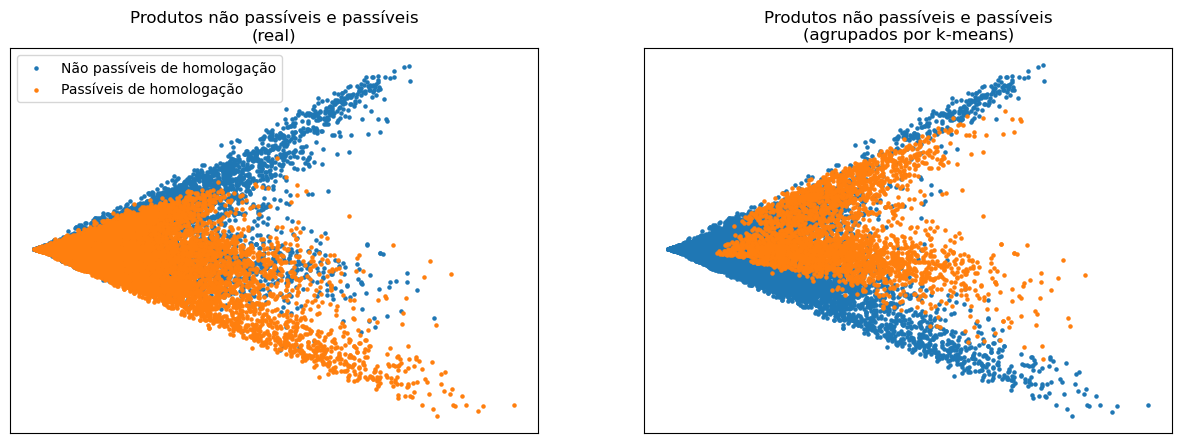

In [18]:
columns_to_keep = ['titulo_clean','passivel_homologacao']
df_docs = df_marketplaces[df_marketplaces['passivel_homologacao']<2][columns_to_keep]

docs_passivel = df_docs['titulo_clean'].values
targets_passivel = df_docs['passivel_homologacao'].values

map_passiveis = {
    0: 'Não passíveis de homologação', 
    1: 'Passíveis de homologação', 
    2: 'Transmissores de RF'}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vectorizer = TfidfVectorizer()
    docs_matrix_passivel = vectorizer.fit_transform(docs_passivel)

kmeans_passivel = KMeans(n_clusters=2, max_iter=500, n_init=1).fit(docs_matrix_passivel)
predicted_targets_passivel = kmeans_passivel.labels_

fig,axs = plt.subplots(1,2,figsize=(15,5))
plot_products_matrix(docs_matrix_passivel,targets=targets_passivel,ax=axs[0],title='Produtos não passíveis e passíveis\n(real)',showlegend=True, legend_map=map_passiveis)
plot_products_matrix(docs_matrix_passivel,targets=predicted_targets_passivel,ax=axs[1],title='Produtos não passíveis e passíveis\n(agrupados por k-means)')

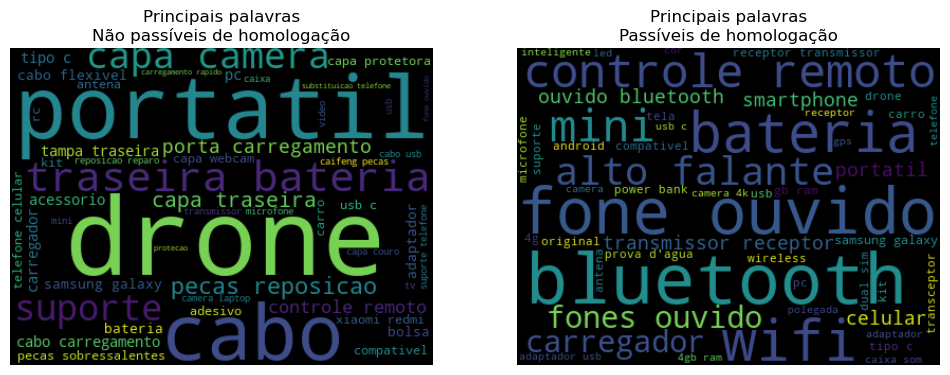

In [19]:
fig, axs = plt.subplots(1,2,figsize=(12,4.2))

targets = [0,1]
for target in targets:
    docs = df_marketplaces[df_marketplaces['passivel_homologacao']==target]['titulo_clean'].values
    title = f'Principais palavras\n{map_passiveis[target]}'
    plot_wordcloud(docs,ax=axs[target],title=title)

### Produtos passíveis e não passíveis de homologação compulsória e transmissores de radiofrequência

Em outra visualização, a amostra de anúncios rotulados foi separada em três grupos: o grupo de produtos não passíveis foi mantido e o grupo de produtos passíveis de homologação compulsória foi dividido em dois: não transmissores e transmissores de radiofrequência.

Assim como na separação em dois grupos, observou-se uma separação entre os grupos com intervalo de sobreposição.

Quando observadas as palavras mais frequentes em cada grupo observa-se, mais detalhadamente, as palavras discriminantes das categorias dos produtos passíveis de homologação.

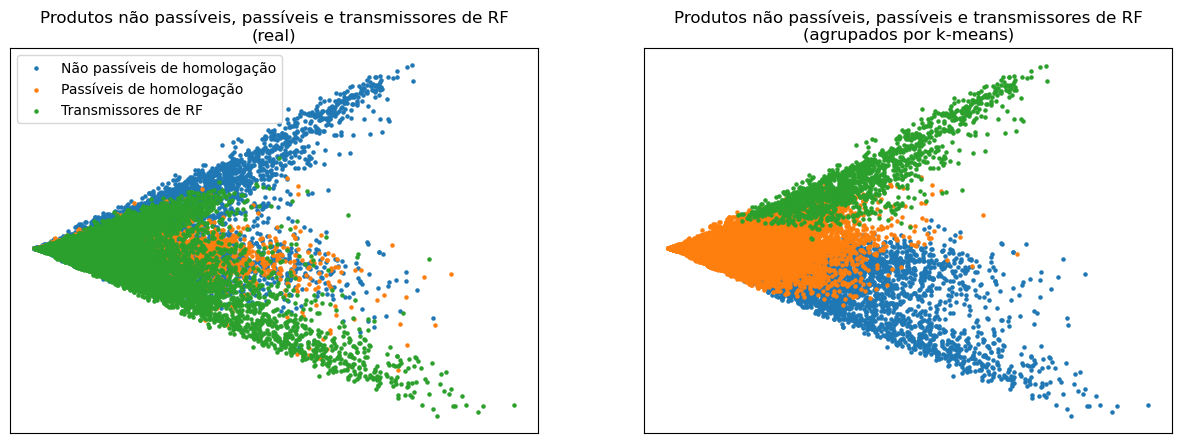

In [20]:
columns_to_keep = ['titulo_clean','grupo']
df_docs = df_marketplaces[df_marketplaces['grupo']<3][columns_to_keep]

docs_passivel = df_docs['titulo_clean'].values
targets_passivel = df_docs['grupo'].values

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vectorizer = TfidfVectorizer()
    docs_matrix_passivel = vectorizer.fit_transform(docs_passivel)

kmeans_passivel = KMeans(n_clusters=3, max_iter=500, n_init=1).fit(docs_matrix_passivel)
predicted_targets_passivel = kmeans_passivel.labels_

fig,axs = plt.subplots(1,2,figsize=(15,5))
plot_products_matrix(docs_matrix_passivel,targets=targets_passivel,ax=axs[0],title='Produtos não passíveis, passíveis e transmissores de RF\n(real)',showlegend=True, legend_map=map_passiveis)
plot_products_matrix(docs_matrix_passivel,targets=predicted_targets_passivel,ax=axs[1],title='Produtos não passíveis, passíveis e transmissores de RF\n(agrupados por k-means)')

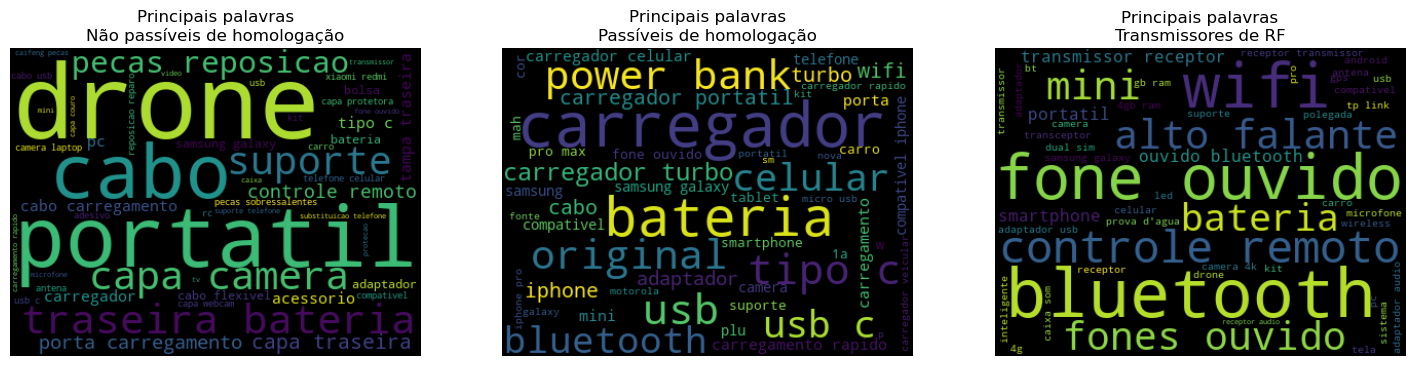

In [21]:
fig, axs = plt.subplots(1,3,figsize=(18,4.2))

targets = [0,1,2]
for target in targets:
    docs = df_marketplaces[df_marketplaces['grupo']==target]['titulo']
    docs = [clean_text(doc) for doc in docs]
    title = f'Principais palavras\n{map_passiveis[target]}'
    plot_wordcloud(docs,ax=axs[target],title=title)

# Construção do classificador

## Parâmetros do Experimento de classificação 2

A amostra de anúncios rotulados foi utilizada para treinar um classificador SGD com os mesmos parâmetros utilizados no treinamento do classificador do [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb) para permitir observar eventuais melhorias de desempenho decorrentes apenas da alteração do conjunto de dados de treinamento.
Foram observadas melhorias em duas métricas de desempenho no conjunto de teste: a área sob a Curva ROC e acurácia.

Acurácia do classificador no conjunto de treinamento: 0.879
Acurácia do classificador no conjunto de teste: 0.877
AUC do classificador no conjunto de treinamento: 0.956
AUC do classificador no conjunto de teste: 0.948

                               precision    recall  f1-score   support

Não passíveis de homologação       0.91      0.79      0.85      1851
    Passíveis de homologação       0.86      0.95      0.90      2498

                    accuracy                           0.88      4349
                   macro avg       0.89      0.87      0.87      4349
                weighted avg       0.88      0.88      0.88      4349



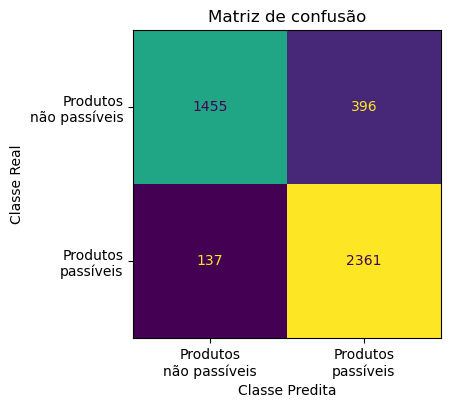

In [22]:
target_names = ['Não passíveis de homologação', 'Passíveis de homologação']
target_names_confusion = ['Produtos\nnão passíveis', 'Produtos\npassíveis']

docs = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['titulo'].values
targets = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['passivel_homologacao'].values

X_train, X_test, y_train, y_test = train_test_split(docs, targets, 
                                                    test_size=0.25, random_state=724)


vectorizer = TfidfVectorizer()
clf = SGDClassifier(loss='log_loss', penalty='l2',
                    alpha=1e-3, random_state=42,
                    max_iter=5, tol=None)


exp_clf3_model_clf2_param = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])
exp_clf3_model_clf2_param.fit(X_train,y_train)

predicted = exp_clf3_model_clf2_param.predict(X_test)
y_scores = exp_clf3_model_clf2_param.decision_function(X_test)
auc_sgd = roc_auc_score(y_test,exp_clf3_model_clf2_param.predict_proba(X_test)[:,1])

precisons,recalls,precisions_recalls_thresholds = precision_recall_curve(y_test,y_scores)
fpr,tpr,auc_thresholds = roc_curve(y_test,y_scores)

print('Acurácia do classificador no conjunto de treinamento: {:.3f}'
     .format(exp_clf3_model_clf2_param.score(X_train, y_train)))
print('Acurácia do classificador no conjunto de teste: {:.3f}'
     .format(exp_clf3_model_clf2_param.score(X_test, y_test)))
print('AUC do classificador no conjunto de treinamento: {:.3f}'
     .format(roc_auc_score(y_train,exp_clf3_model_clf2_param.predict_proba(X_train)[:,1])))
print('AUC do classificador no conjunto de teste: {:.3f}'
     .format(roc_auc_score(y_test,exp_clf3_model_clf2_param.predict_proba(X_test)[:,1])))


print('\n',classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax, colorbar=False)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)

ax.set_xlabel('Classe Predita')
ax.set_ylabel('Classe Real')
_ = ax.set_title('Matriz de confusão')

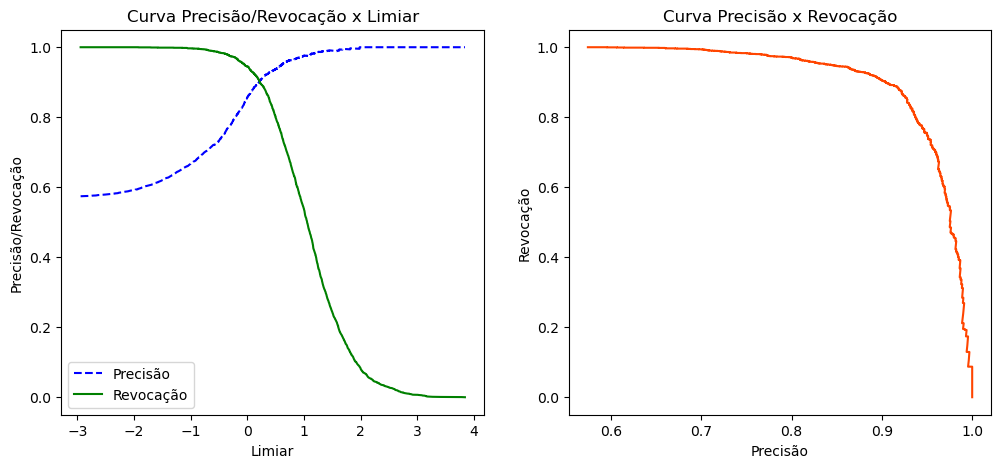

In [23]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(precisions_recalls_thresholds, precisons[:-1], 'b--', label='Precisão')
axs[0].plot(precisions_recalls_thresholds, recalls[:-1], 'g-', label='Revocação')

axs[0].set_xlabel('Limiar')
axs[0].set_ylabel('Precisão/Revocação')
axs[0].set_title('Curva Precisão/Revocação x Limiar')
axs[0].legend()

axs[1].plot(precisons,recalls,'orangered')
axs[1].set_title('Curva Precisão x Revocação')
axs[1].set_xlabel('Precisão')
axs[1].set_ylabel('Revocação')

plt.show()

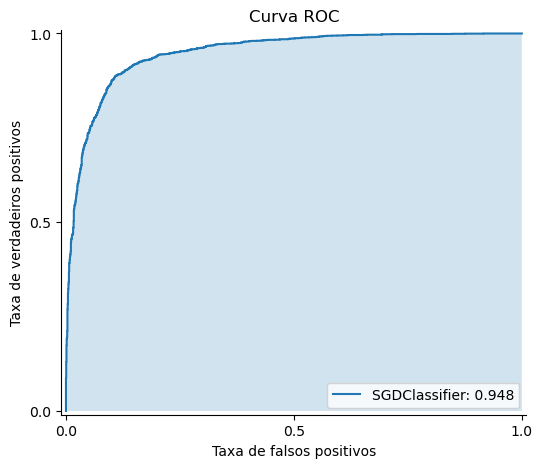

In [24]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

ax.plot(fpr,tpr,label=f'SGDClassifier: {auc_sgd:.3f}')

ax.fill_between(fpr,tpr,alpha=0.2)
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)

ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])

# remove the frame of the chart
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Curva ROC')
ax.set_xlabel('Taxa de falsos positivos')
ax.set_ylabel('Taxa de verdadeiros positivos')
ax.legend(loc='lower right')

plt.show()

## Ajuste dos hiperparâmetros do classificador

Em busca de melhores resultados de desempenho foram testados ajustes finos nos parâmetros utilizados no treinamento do classificador do [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb). Com os ajustes realizados obteve-se uma leve melhora no desempenho do classificador, que reflete diretamente nas curvas de precisão e revocação, permitindo um ajuste no limiar do classificador em uma faixa mais ampla.

Acurácia do classificador no conjunto de treinamento: 0.996
Acurácia do classificador no conjunto de teste: 0.917
AUC do classificador no conjunto de treinamento: 1.000
AUC do classificador no conjunto de teste: 0.970

                              precision    recall  f1-score   support

Não passíveis de homologação       0.92      0.88      0.90      1851
    Passíveis de homologação       0.92      0.94      0.93      2498

                    accuracy                           0.92      4349
                   macro avg       0.92      0.91      0.91      4349
                weighted avg       0.92      0.92      0.92      4349

CPU times: total: 1.41 s
Wall time: 2.21 s


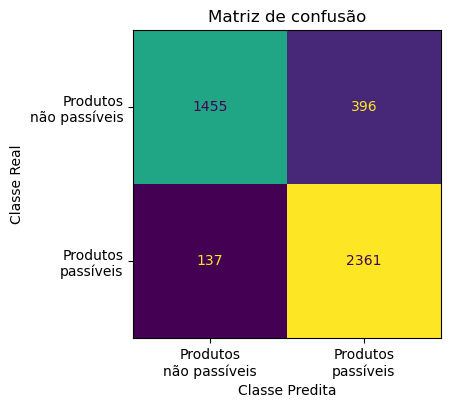

In [25]:
%%time
# stop words
stop_words = stopwords.words('portuguese')
stop_words.extend(stopwords.words('english'))

# vetorizar as palavras por contagem
vectorizer = CountVectorizer(ngram_range=(1,2),stop_words=stop_words)

# transformar vetores aplicando TF-IDF
transformer = TfidfTransformer()

# classificardor SGD
clf = SGDClassifier(alpha=1e-5, loss='log_loss', penalty='l2')

# juntar tudo em pipeline
exp_clf3_model = Pipeline(steps=[('vectorizer',vectorizer),('transformer',transformer),('clf',clf)])

# conjunto de dados
docs = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['titulo']
targets = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['passivel_homologacao']

X_train, X_test, y_train, y_test = train_test_split(docs, targets, test_size=0.25, random_state=724)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    exp_clf3_model.fit(X_train,y_train)

# persist model
dump(exp_clf_3,FILE_MODEL_CLF3)
    
predicted_clf3 = exp_clf3_model.predict(X_test)
y_scores_clf3 = exp_clf3_model.decision_function(X_test)
auc_sgd = roc_auc_score(y_test,exp_clf3_model.predict_proba(X_test)[:,1])

precisons,recalls,precisions_recalls_thresholds = precision_recall_curve(y_test,y_scores_clf3)
fpr,tpr,auc_thresholds = roc_curve(y_test,y_scores_clf3)

print('Acurácia do classificador no conjunto de treinamento: {:.3f}'
     .format(exp_clf3_model.score(X_train, y_train)))
print('Acurácia do classificador no conjunto de teste: {:.3f}'
     .format(exp_clf3_model.score(X_test, y_test)))
print('AUC do classificador no conjunto de treinamento: {:.3f}'
     .format(roc_auc_score(y_train,exp_clf3_model.predict_proba(X_train)[:,1])))
print('AUC do classificador no conjunto de teste: {:.3f}'
     .format(roc_auc_score(y_test,exp_clf3_model.predict_proba(X_test)[:,1])))

print()
print(classification_report(y_test, predicted_clf3, target_names=target_names))

fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax, colorbar=False)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)

ax.set_xlabel('Classe Predita')
ax.set_ylabel('Classe Real')
_ = ax.set_title('Matriz de confusão')

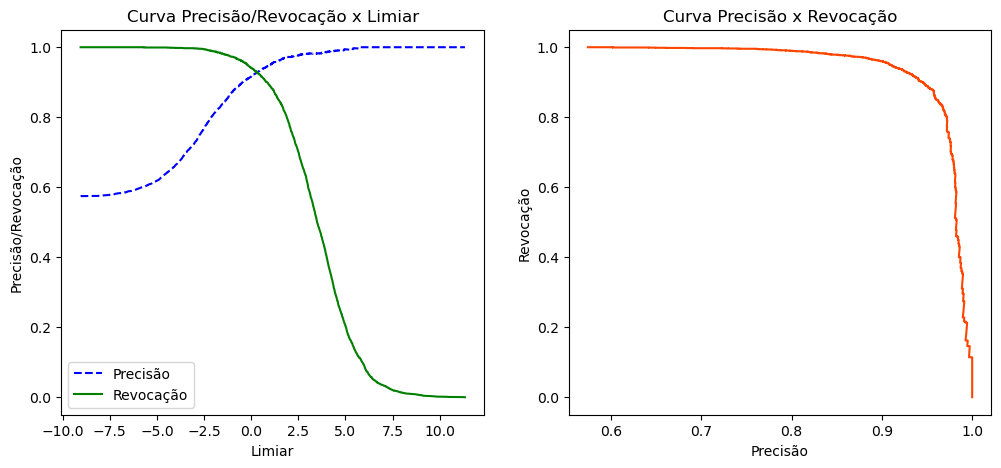

In [26]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(precisions_recalls_thresholds, precisons[:-1], 'b--', label='Precisão')
axs[0].plot(precisions_recalls_thresholds, recalls[:-1], 'g-', label='Revocação')

axs[0].set_xlabel('Limiar')
axs[0].set_ylabel('Precisão/Revocação')
axs[0].set_title('Curva Precisão/Revocação x Limiar')
axs[0].legend()

axs[1].plot(precisons,recalls,'orangered')
axs[1].set_title('Curva Precisão x Revocação')
axs[1].set_xlabel('Precisão')
axs[1].set_ylabel('Revocação')

plt.show()

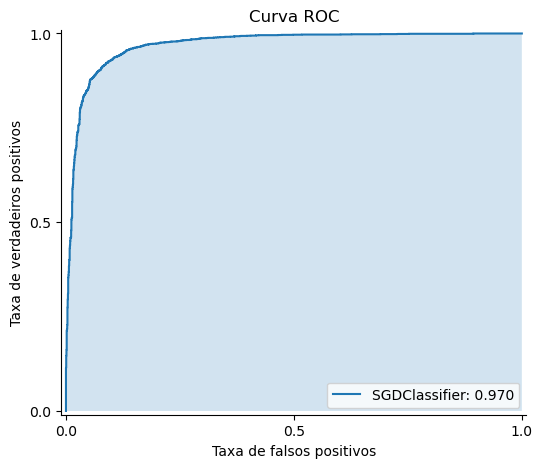

In [27]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

ax.plot(fpr,tpr,label=f'SGDClassifier: {auc_sgd:.3f}')

ax.fill_between(fpr,tpr,alpha=0.2)
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)

ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])

# remove the frame of the chart
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Curva ROC')
ax.set_xlabel('Taxa de falsos positivos')
ax.set_ylabel('Taxa de verdadeiros positivos')
ax.legend(loc='lower right')

plt.show()

# Avaliação da capacidade de generalização

Até a etapa de treinamento o desempenho do classificador foi avaliado com dados preparados para esse fim, dividos em subconjuntos para treinamento e teste de desempenho. 

Um classificador adequado deve ser capaz de predizer corretamente o rótulo de novos dados. Ele será útil se for capaz de generalizar bem ao encontrar dados novos, ou seja, apresentar em dados novos desempenho semelhante ao obtido durante o treinamento.

Para avaliar a capacidade de generalização do classificador construído neste experimento foram utilizados dados de supervisão de mercado obtidos em ações de inspeções realizadas entre os dias 1º e 5 de junho de 2024. Nessas inspeções foram coletadas manualmente amostras de anúncios de *marketplaces* e cada anúncio foi avaliado quanto à necessidade de homologação ou não, ou seja, cada anúncio foi rotulado como não passível ou passível de homologação.

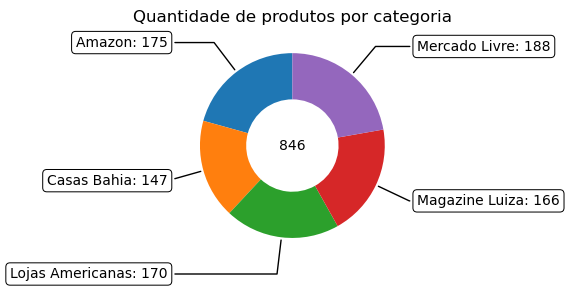

In [28]:
file_mercado = 'assets/supervisao_mercado.xlsx'
dict_df_mercado = pd.read_excel(
    file_mercado,
    sheet_name=None,
    usecols=[2,8,10],
    names=['texto_busca', 'titulo', 'passivel_homologacao'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

df_list = []
for key in dict_df_mercado.keys():
    df = dict_df_mercado[key]
    df['marketplace'] = key
    df_list.append(df)
    
df_mercado = pd.concat(df_list)
df_mercado = df_mercado.dropna()
df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)

map_marketplaces = {
    'Amazon': 'Amazon', 
    'Americanas': 'Lojas Americanas',
    'CasasBahia': 'Casas Bahia',
    'Magalu': 'Magazine Luiza', 
    'MercadoLivre': 'Mercado Livre'
}

df_mercado['marketplace'] = df_mercado['marketplace'].map(map_marketplaces)

df_count_markeplace = df_mercado[['texto_busca', 'marketplace']].groupby('marketplace',as_index=False).count()
df_count_markeplace.columns = ['Marketplace', 'Quantidade']
df_count_markeplace['Marketplace'] = df_count_markeplace['Marketplace']

labels = df_count_markeplace.apply(lambda row: f'{row.Marketplace}: {row.Quantidade:,d}'.replace(',','.'),axis=1)
values = df_count_markeplace['Quantidade'].to_numpy()
title = 'Quantidade de produtos por categoria'
startangle = 90

total = df_count_markeplace['Quantidade'].sum() 

plot_donut(labels, values, title, startangle, total)

## Avaliação do desempenho com todos os dados de supervisão de mercado

Os dados de supervisão de mercado foram apresentados ao classificador construído no [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb) e aos classificadores construído neste experimento, assim definidos:

- Classificador 2: classificador construído no [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb) com 2.091 amostras de anúncios extraídas do *marketplace* Amazon; 
- Classificador 3.0: classificador construído neste experimento utilizando os mesmos hiperparâmetros do Classificador 2; e
- Classificador 3.1: classificador construído neste experimento com ajuestes nos hiperparâmetros para melhor desempenho.

Nesta avaliação o desempenho dos três classificadores foi avaliado pela Área sob a Curva ROC e Acurácia, com os seguintes resultados obtidos por cada classificador:

$$
\begin{array}{lcc}
\hline & \text { Área sob a curva ROC } & \text { Acurácia }\\
\hline \text { Classificador 2 } & 0.662 & 0.433 \\
\hline \text { Classificador 3.0 } & 0.928 & 0.865 \\
\hline \text { Classificador 3.1 } & 0.959 & 0.903 \\
\hline
\end{array}
$$

Os resultados obtidos demonstram a melhora no desempenho proporcionado tanto pelo aumento da quantidade de dados de treinamento, quando comparados o classificador 3.0 e 2, quanto por ajustes nos hiperparâmetros do classificador, quando comparados os classificadores 3.1 e 3.0.


Classificador 2
Acurácia: 0.433
________________________________________

Classificador 3.0
Acurácia: 0.865
________________________________________

Classificador 3.1
Acurácia: 0.900
________________________________________



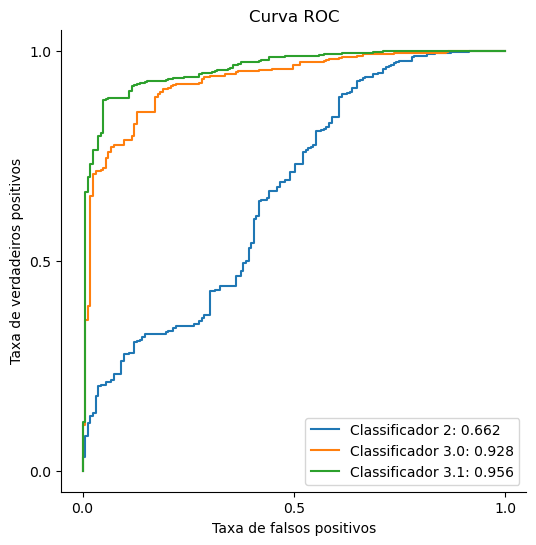

In [29]:
exp_clf2_model = load(FILE_MODEL_CLF2)

models = [
    (exp_clf2_model,'Classificador 2'), 
    (exp_clf3_model_clf2_param, 'Classificador 3.0'), 
    (exp_clf3_model, 'Classificador 3.1')]

results = plot_models_benchmark(models,df_mercado)

## Avaliação do desempenho dados de supervisão de mercado dos *marketplaces* Casas Bahia e Lojas Americanas

A avaliação do desempenho dos classificadores com todos os dados de supervisão de mercado demonstrou o ganho proporcionado pela utilização de uma quantidade maior de exemplos, entretanto, a utilização de dados de *marketplaces* que foram objeto de rotulagem pode ter superestimado o desempenho dos classificadores 3.0 e 3.1. 

Embora os dados utilizados nessa avaliação não tenham sido os mesmos utilizados no treinamento classificadores 3.0 e 3.1, entre eles há 9 anúncios do mesmo produto (título idêntico), utilizados no treinamento. Embora a quantidade seja pequena e represente apenas 0,067% do tamanho da amostra, podem haver anúncios com títulos semelhantes, e ambos fatores podem levar a uma estimativa mais otimista do desempenho.

Para uma avaliação com menor influência de dados iguais ou semelhantes uma segunda avaliação foi feita, desta vez, com dados apenas dos *marketplaces* Casas Bahia e Lojas Americanas e os resultados obtidos foram, semelhantemente bons:

$$
\begin{array}{lcc}
\hline & \text { Área sob a curva ROC } & \text { Acurácia }\\
\hline \text { Classificador 2 } & 0.508 & 0.338 \\
\hline \text { Classificador 3.0 } & 0.891 & 0.789 \\
\hline \text { Classificador 3.1 } & 0.930 & 0.845 \\
\hline
\end{array}
$$



Classificador 2
Acurácia: 0.338
________________________________________

Classificador 3.0
Acurácia: 0.789
________________________________________

Classificador 3.1
Acurácia: 0.839
________________________________________



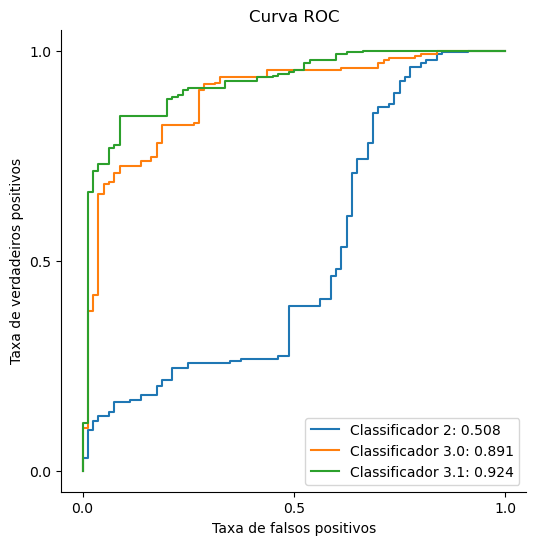

In [30]:
df_nao_rotulados = df_mercado[df_mercado['marketplace'].isin(['Lojas Americanas', 'Casas Bahia'])]
results = plot_models_benchmark(models,df_nao_rotulados)

# Conclusão e próximos passos

O presente experimento apresentou uma análise exploratória dos dados extraídos dos marketplace da Amazon, Magazine Luiza e Mercado Livre e delineou uma linha base para avaliação de desempenho de outros classificadores que venham a ser construídos para identificação de anúncios de produtos passíveis de homologação compulsória pela Anatel. 

O desempenho do Classificador 3.1, medido pela área sob a Curva ROC com o subconjunto de dados de teste, foi de $0.970$, ante $0.932$ obtido no [Experimento de classificação 2](https://github.com/InovaFiscaliza/dados-pacp/blob/main/experimentos/experimento_classificacao_amazon.ipynb). Já quando submetidos a novos dados para validação, no cenário mais desfavorável, a Área sob a Curva ROC do Classificador 3.1 foi de $0.930$. 

Foi apresentado ainda que sem os dados de rotulados utilizados para treinamento do Classificador 3.1 o desempenho do Classificador 2.0 não chegaria a níveis adequados para sua utilização em aplicações reais, pois a Área sob a Curva ROC cenário mais favorável (com todos os dados de supervisão de mercado) $0.508$, desempenho muito próximo do classificador aleatório.

O Classificador 3.1 já pode ser utilizado em conjunto com o Regulatron para indicar se um produto é passível de homologação compulsória ou não, de forma a reduzir a quantidade de exemplos a serem analisados por humanos em eventual Ação de Inspeção, ou até mesmo para subsidiar a geração de relatórios automatizados. 

Para que os resultados sejam ainda mais robustos e resultem em um classificador com melhor desempenho, será necessário a pesquisa e desenvolvimento de outros modelos de classificação e contínua rotulagem de novos dados para retreinamento do classificador.